In [1]:
using LinearAlgebra
using Convex
using SCS
using PyPlot
using ForwardDiff
using LaTeXStrings

In [2]:
struct Quadratic
  minimum::Float64
  minimizer::Array{Float64}
  growth::Float64
end

function addWeightedQuadratics(eta1, quad1, eta2, quad2)
#Returns the quadratic eta1*quad1 + eta2*quad2
    w1 = quad1.growth*eta1/(quad1.growth*eta1+quad2.growth*eta2)
    w2 = quad2.growth*eta2/(quad1.growth*eta1+quad2.growth*eta2)
    new_minimizer = w1*quad1.minimizer+ w2*quad2.minimizer

    new_minimum = (eta1+eta2)*w1*quad1.minimum + (eta1+eta2)*w2*quad2.minimum + 0.5*(eta1*quad1.growth + eta2*quad2.growth)*w1*w2*norm(quad1.minimizer-quad2.minimizer,2)^2 
    
    new_growth = eta1*quad1.growth + eta2*quad2.growth
    
    return Quadratic(new_minimum, new_minimizer, new_growth)
end


function subgradientMethod(f, gradf, xtrue, mu, T, dim, lambda_list, beta)
#Given oracle functions (f, gradf), strong convexity mu, step bound T, and dimension dim
#    We run the subgradient method with alpha_k = k^p/mu(\sum i^p+beta)
#    which is equivalent to dual averaging with \lambda_k=k^p and \beta_k=beta
#Returns three lists of the primal and dual objective values and averaged iterate primal gap.
#    Our theory shows these should be M^2/mu*T from the true optimal objective value

    #We initialize at the origin for ease (start counting from 1 to avoid division by zero)    
    x1 = zeros(dim)
    basicQuadratic = Quadratic(0.0,x1,1)
    xi = x1
    x_average = x1    #equals \sum_i sigma_i x_i
    f_average = f(x1) #equals \sum_i sigma_i f(x_i)
    modeli = Quadratic(f(x1)-norm(gradf(x1),2)^2/(2*mu), x1 - gradf(x1)/mu, mu) #equals \sum_i theta_i quadratic_i
    sum_of_lambda_i = lambda_list[1]

    #We will record primal and dual values based on the weightings below
    #Primal: sigma_k = lambda_list[k]/sum_{i=1}^{k}lambda_list[i] = eta_k
    #Dual:   eta_k = lambda_list[k]/sum_{i=1}^{k}lambda_list[i]
    primal_values   = zeros(T)
    dual_values     = zeros(T)
    average_iterate_primal_values = zeros(T)
    f_list = zeros(T)
    distance_values = zeros(T)    
    gradient_list = zeros(n,T)
    for i in 1:T
        #Record current primal gap, dual gap, and obj at average primal iterate
        primal_values[i] = f_average
        dual_values[i]   = modeli.minimum
        average_iterate_primal_values[i] = f(x_average)
        f_list[i] = f(xi)
        gradient_list[:,i] = gradf(xi)

        #Compute penalized quadratic and update to next iterate
        penalizedQuadratic = addWeightedQuadratics(1.0, modeli, beta/sum_of_lambda_i, basicQuadratic)
        xi = penalizedQuadratic.minimizer 
        distance_values[i] = norm(xi-xtrue,2)^2
        
        #Compute new function values and gradients (at the newly computed next x_i) and update the model        
        fi = f(xi)
        gi = gradf(xi)
        eta = lambda_list[i+1]/(sum_of_lambda_i + lambda_list[i+1])
        modeli = addWeightedQuadratics(1.0 - eta, modeli, eta, Quadratic(fi - norm(gi,2)^2/(2*mu), xi-gi/mu, mu))
        x_average = (1.0-eta)*x_average + eta*xi
        f_average = (1.0-eta)*f_average + eta*f(xi)

        sum_of_lambda_i += lambda_list[i+1]
    end
    return primal_values, dual_values,average_iterate_primal_values,f_list,gradient_list,distance_values
end

subgradientMethod (generic function with 1 method)

In [3]:
n = 100 #Variable dimension
m = 100 #Number of constraints

xtrue = randn(n) # minimizer 


100-element Vector{Float64}:
  0.49642641226040607
 -1.5148431277421546
  0.10828550585003606
  0.5363374801283691
 -0.08451554274852588
 -0.541666262672912
  1.4628993118965699
  1.2936676118272814
  0.3543114531576226
 -0.6325093264379493
  0.11236892336753977
  0.3229875057897678
 -0.26276528273236294
  ⋮
 -1.070876749547669
  0.9047302226801786
 -1.5530798020469347
  0.256351990618707
  0.29868946058986534
  0.8222780974464257
  0.9504435042572807
 -1.2136306995279573
 -0.13666618048139828
 -0.2093527361283265
 -0.45477153470667475
 -0.5414800162137532

In [4]:
#Generating Random Test Data

#setting for \|A1x-b1\|
p1 = 1
N1 = randn(m,n)
function A1(xtrue,m,n)
    A = N1
    return A
end

#setting for \|A2x-b2\|
p2 = 2

N2=randn(m,n)
function A2(xtrue,m,n,sigma)
    A = sigma*N2 + Matrix{Int}(I, n, m)
    return A
end



A2 (generic function with 1 method)

In [5]:
# find T0:= inf{k|alpha_k >= 1/M1} 
function find_T_0(lambda_list,M1,mu,T,beta) #How about alpha_k in general case?
    lambda_sum = 0
    for i in 1:T
        lambda_sum += lambda_list[i]
        if  lambda_list[i]/(mu*lambda_sum+beta)<=1/M1
            return i-1 
        end
    end
    return T
end

# compute C0:
function find_C_0(lambda_list,f_list,M1,mu,T0,beta)
    
    sum_for_k=0
    if T0==0 return 0 end
    lambda_sum=0
    for k in 1:T0
        lambda_sum += lambda_list[k]
        #alpha_k = lambda_list[k]/(mu*lambda_sum+beta)
        if M1*(lambda_list[k]/(mu*lambda_sum+beta))-1>0
            sum_for_k += lambda_list[k]*(M1*(lambda_list[k]/(mu*lambda_sum+beta))-1)*(f_list[k]-0) #p*=0
        end
        if M1*(lambda_list[k]/(mu*lambda_sum+beta))-1<=0
        sum_for_k += 0
        end
    end
    return sum_for_k
end

find_C_0 (generic function with 1 method)

In [6]:
#primal gap bound, dual gap bound, distance optimal bound
function three_important_bounds(lambda_list,A11,A21,beta,xtrue,x0,T)
    A1 = A11
    A2 = A21
    b1 = A1*xtrue
    b2 = A2*xtrue
    A = adjoint(A21)*A21
    mu = eigmin(A)
    norm_A1 = 0
    for i in 1:n
        a = norm(A1[:,i],2)
        norm_A1 += a    
    end
    M0= 2*sqrt(2)*norm_A1
    M1 = 4*eigmax(A)
    obj = x -> norm(A1*x-b1,p1)^p1 + 0.5*norm(A2*x-b2,p2)^p2
    objGrad = x -> ForwardDiff.gradient(obj, x)
    _, dual_values, _, f_list,_,_ = subgradientMethod(obj, objGrad, xtrue, mu, T, n, lambda_list,beta)
    C0 = find_C_0(lambda_list,f_list,M1,mu,find_T_0(lambda_list,M1,mu,T,beta),beta) 
    println(find_T_0(lambda_list,M1,mu,T,beta))
    println((M0^2)/mu)
    println(C0)
    sums_of_lambdas = zeros(T)
    sums_of_lambdas[1]=lambda_list[1]
    alpha_list = zeros(T)
    alpha_list[1] = lambda_list[1]/(mu*lambda_list[1]+beta)
    for i in 2:T
        sums_of_lambdas[i] = sums_of_lambdas[i-1]+lambda_list[i]
        alpha_list[i] = lambda_list[i]/(mu*sums_of_lambdas[i]+beta)
    end
    two_sums=zeros(T)
    two_sums[1]=lambda_list[1]*alpha_list[1]
    for i in 2:T
        two_sums[i] = two_sums[i-1]+lambda_list[i]*alpha_list[i]
    end
    primal_gap_bound=zeros(T)
    dual_gap_bound=zeros(T)
    distance_optimal_bound=zeros(T)
    
    for t in 1:T        
        primal_gap_bound[t]=((M0^2)*two_sums[t]+C0)/sums_of_lambdas[t]
        distance_optimal_bound[t]=(2/mu)*((M0^2)*two_sums[t]+C0)/sums_of_lambdas[t]
        dual_gap_bound[t]=((M0^2)*two_sums[t]+C0)/sums_of_lambdas[t]
    end
    return primal_gap_bound,dual_gap_bound,distance_optimal_bound
end             

three_important_bounds (generic function with 1 method)

In [7]:
#beta=0,lambda defined by (16)
function find_lambdas(T,mu)
    lambda_list=[1.0]
    alpha_list=[1/mu]
    for i in 2:T
        s1=0
        s2=0
        s3=0
        for j in 1:i-1
            s1+=lambda_list[j]
            s2+=lambda_list[j]*alpha_list[j]
            s3+=lambda_list[j]*((2/mu)-alpha_list[j])
        end
        lambda = s1*s2/s3
        alpha=lambda/(mu*(s1+lambda))
        append!(lambda_list,[lambda])
        append!(alpha_list,[alpha])
    end
    return lambda_list
end

find_lambdas (generic function with 1 method)

In [8]:
lambda_list=find_lambdas(10,2)

10-element Vector{Float64}:
 1.0
 1.0
 1.2
 1.402247191011236
 1.6025022825561854
 1.8005370241095677
 1.9966248956032784
 2.1910717002296307
 2.384138702721359
 2.576037291010721

## $\sigma = 0$

In [9]:
sigma=0

A1_sigma = A1(xtrue,n,m)
A2_sigma = A2(xtrue,n,m,sigma)
b1_sigma = A1_sigma*xtrue
b2_sigma = A2_sigma*xtrue
obj_sigma = x -> norm(A1_sigma*x-b1_sigma,p1)^p1 + 0.5*norm(A2_sigma*x-b2_sigma,p2)^p2
objGrad_sigma = x -> ForwardDiff.gradient(obj_sigma, x)
mu_sigma = eigmin(A2_sigma'*A2_sigma)

T_sigma = 10000
lambda_list_sigma = [i*1.00 for i in 1:T_sigma+1]
beta_sigma = 0

primal_values1, dual_values1,average_iterate_primal_values1,f_list1,_,distance_values1 = subgradientMethod(obj_sigma, objGrad_sigma, xtrue, mu_sigma, T_sigma, n, lambda_list_sigma, beta_sigma)
primal_gap_bound1,dual_gap_bound1,distance_optimal_bound1=three_important_bounds(lambda_list_sigma,A1_sigma,A2_sigma,beta_sigma,xtrue,zeros(n),T_sigma)


6
7.9926416154745435e6
147246.08089252864


([8.139887696367072e6, 6.265581061222154e6, 5.1309509344797125e6, 4.357393219163755e6, 3.793000103384119e6, 3.361746328170252e6, 3.020849847094848e6, 2.7442482324552294e6, 2.5151042505831653e6, 2.3220321261953022e6  …  3196.8053158929915, 3196.485660686518, 3196.166069402791, 3195.8465420226385, 3195.5270785268935, 3195.2076788963996, 3194.888343112006, 3194.569071154571, 3194.2498630049595, 3193.9307186440437], [8.139887696367072e6, 6.265581061222154e6, 5.1309509344797125e6, 4.357393219163755e6, 3.793000103384119e6, 3.361746328170252e6, 3.020849847094848e6, 2.7442482324552294e6, 2.5151042505831653e6, 2.3220321261953022e6  …  3196.8053158929915, 3196.485660686518, 3196.166069402791, 3195.8465420226385, 3195.5270785268935, 3195.2076788963996, 3194.888343112006, 3194.569071154571, 3194.2498630049595, 3193.9307186440437], [1.6279775392734144e7, 1.2531162122444307e7, 1.0261901868959425e7, 8.71478643832751e6, 7.586000206768238e6, 6.723492656340504e6, 6.041699694189696e6, 5.488496464910459e6

## $\sigma=0.01$

In [10]:
sigma=0.01

A1_sigma = A1(xtrue,n,m)
A2_sigma = A2(xtrue,n,m,sigma)
b1_sigma = A1_sigma*xtrue
b2_sigma = A2_sigma*xtrue
obj_sigma = x -> norm(A1_sigma*x-b1_sigma,p1)^p1 + 0.5*norm(A2_sigma*x-b2_sigma,p2)^p2
objGrad_sigma = x -> ForwardDiff.gradient(obj_sigma, x)
mu_sigma = eigmin(A2_sigma'*A2_sigma)

T_sigma = 10000
lambda_list_sigma = [i*1.00 for i in 1:T_sigma+1]
beta_sigma = 0

primal_values2, dual_values2,average_iterate_primal_values2,f_list2,_,distance_values2 = subgradientMethod(obj_sigma, objGrad_sigma, xtrue, mu_sigma, T_sigma, n, lambda_list_sigma, beta_sigma)
primal_gap_bound2,dual_gap_bound2,distance_optimal_bound2=three_important_bounds(lambda_list_sigma,A1_sigma,A2_sigma,beta_sigma,xtrue,zeros(n),T_sigma)


12
1.0681917639916195e7
698544.0974176718


([1.1380461737333864e7, 8.54100619685182e6, 6.940982508404959e6, 5.8736963274295665e6, 5.102677289388177e6, 4.516762769147979e6, 4.0551919293557466e6, 3.6815402729515648e6, 3.3725089239579e6, 3.112446727533032e6  …  4272.441212986376, 4272.014001704684, 4271.586875854366, 4271.159835409794, 4270.7328803453565, 4270.30601063545, 4269.879226254478, 4269.45252717686, 4269.025913377021, 4268.599384829399], [1.1380461737333864e7, 8.54100619685182e6, 6.940982508404959e6, 5.8736963274295665e6, 5.102677289388177e6, 4.516762769147979e6, 4.0551919293557466e6, 3.6815402729515648e6, 3.3725089239579e6, 3.112446727533032e6  …  4272.441212986376, 4272.014001704684, 4271.586875854366, 4271.159835409794, 4270.7328803453565, 4270.30601063545, 4269.879226254478, 4269.45252717686, 4269.025913377021, 4268.599384829399], [3.041926832977366e7, 2.2829579792529747e7, 1.8552815717730295e7, 1.5700025956376046e7, 1.363913989156866e7, 1.2073026721394893e7, 1.0839276496412527e7, 9.840528795276985e6, 9.0145071676560

## $\sigma=0.05$

In [11]:
sigma=0.05

A1_sigma = A1(xtrue,n,m)
A2_sigma = A2(xtrue,n,m,sigma)
b1_sigma = A1_sigma*xtrue
b2_sigma = A2_sigma*xtrue
obj_sigma = x -> norm(A1_sigma*x-b1_sigma,p1)^p1 + 0.5*norm(A2_sigma*x-b2_sigma,p2)^p2
objGrad_sigma = x -> ForwardDiff.gradient(obj_sigma, x)
mu_sigma = eigmin(A2_sigma'*A2_sigma)

T_sigma = 10000
lambda_list_sigma = [i*1.00 for i in 1:T_sigma+1]
beta_sigma = 0

primal_values3, dual_values3,average_iterate_primal_values3,f_list3,_,distance_values3 = subgradientMethod(obj_sigma, objGrad_sigma, xtrue, mu_sigma, T_sigma, n, lambda_list_sigma, beta_sigma)
primal_gap_bound3,dual_gap_bound3,distance_optimal_bound3=three_important_bounds(lambda_list_sigma,A1_sigma,A2_sigma,beta_sigma,xtrue,zeros(n),T_sigma)


161
5.4194667623146944e7
2.6627491452899132e23


([2.662749145289914e23, 8.875830484299716e22, 4.437915242149859e22, 2.662749145289916e22, 1.7751660968599446e22, 1.2679757834713894e22, 9.509818376035425e21, 7.396525403583111e21, 5.917220322866491e21, 4.841362082345313e21  …  5.334563207168142e15, 5.333495547164708e15, 5.33242820765157e15, 5.331361188500466e15, 5.330294489583201e15, 5.329228110771643e15, 5.328162051937724e15, 5.327096312953441e15, 5.326030893690852e15, 5.324965794022083e15], [2.662749145289914e23, 8.875830484299716e22, 4.437915242149859e22, 2.662749145289916e22, 1.7751660968599446e22, 1.2679757834713894e22, 9.509818376035425e21, 7.396525403583111e21, 5.917220322866491e21, 4.841362082345313e21  …  5.334563207168142e15, 5.333495547164708e15, 5.33242820765157e15, 5.331361188500466e15, 5.330294489583201e15, 5.329228110771643e15, 5.328162051937724e15, 5.327096312953441e15, 5.326030893690852e15, 5.324965794022083e15], [3.6109915053219265e24, 1.2036638351073092e24, 6.018319175536548e23, 3.6109915053219296e23, 2.4073276702146

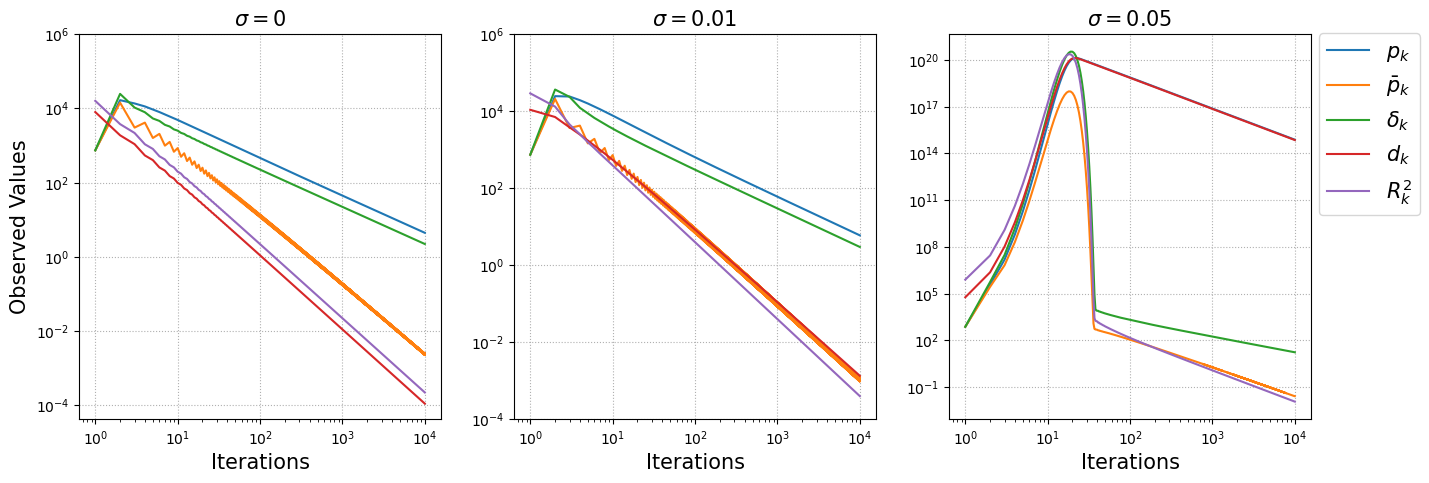

In [12]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(17, 5))

y1 = [10.0^i for i in -4.0 :6]
function compute_yticks(y_values)
    min_power = floor(Int, log10(minimum(y_values)))
    max_power = ceil(Int, log10(maximum(y_values)))
    return [10.0^i for i in min_power:2:max_power]
end

ax1.loglog(1:T_sigma, primal_values1 - zeros(T_sigma))
ax1.loglog(1:T_sigma, average_iterate_primal_values1 - zeros(T_sigma))
ax1.loglog(1:T_sigma, f_list1 - zeros(T_sigma)) #f(x_k)-p*
ax1.loglog(1:T_sigma, zeros(T_sigma)-dual_values1)
ax1.loglog(1:T_sigma, distance_values1 - zeros(T_sigma))
ax1.grid(linestyle =":")
ax1.set_ylabel("Observed Values",fontsize=15)
ax1.set_xlabel("Iterations",fontsize=15)
ax1.set_title(L"\sigma = 0",fontsize=15)
ax1.set_yticks(compute_yticks(y1))

ax2.loglog(1:T_sigma, primal_values2 - zeros(T_sigma))
ax2.loglog(1:T_sigma, average_iterate_primal_values2 - zeros(T_sigma))
ax2.loglog(1:T_sigma, f_list2 - zeros(T_sigma))
ax2.loglog(1:T_sigma, zeros(T_sigma)-dual_values2)
ax2.loglog(1:T_sigma, distance_values2 - zeros(T_sigma))
ax2.set_xlabel("Iterations",fontsize=15)
ax2.grid(linestyle =":")
ax2.set_title(L"\sigma = 0.01",fontsize=15)
ax2.set_yticks(compute_yticks(y1))

ax3.loglog(1:T_sigma, primal_values3 - zeros(T_sigma), label=L"p_k")
ax3.loglog(1:T_sigma, average_iterate_primal_values3 - zeros(T_sigma), label=L"\bar p_k")
ax3.loglog(1:T_sigma, f_list3 - zeros(T_sigma), label=L"\delta_k")
ax3.loglog(1:T_sigma, zeros(T_sigma)-dual_values3, label=L"d_k")
ax3.loglog(1:T_sigma, distance_values3 - zeros(T_sigma), label=L"R_k^2")
ax3.set_xlabel("Iterations",fontsize=15)
ax3.grid(linestyle =":")
ax3.set_title(L"\sigma = 0.05",fontsize=15)

fig.legend(loc="center right", ncol=1, bbox_to_anchor=(0.92, 0.7),fontsize=15)
fig.subplots_adjust(right=0.85)
savefig("figure21_sigma_before",bbox_inches ="tight",pad_inches = 0)

## $\sigma=0$, after modification on $\lambda$

In [13]:
#\alpha_k = \min{1/L_1, 2/mu(k+1)}, beta=0
function find_lambdas_after_modification(T,mu,M1)
    lambda_list=[1.0] #fix lambda_0=1
    alpha_list=[1/mu]
    for i in 2:T
        alpha=min(1/M1, 2/(mu*(i+1))) 
        lambda=(alpha/(1-mu*alpha))*(lambda_list[i-1]/alpha_list[i-1])
        append!(lambda_list,[lambda])
        append!(alpha_list,[alpha])
    end
    return lambda_list
end

find_lambdas_after_modification (generic function with 1 method)

In [14]:
sigma=0

A1_sigma = A1(xtrue,n,m)
A2_sigma = A2(xtrue,n,m,sigma)
b1_sigma = A1_sigma*xtrue
b2_sigma = A2_sigma*xtrue
obj_sigma = x -> norm(A1_sigma*x-b1_sigma,p1)^p1 + 0.5*norm(A2_sigma*x-b2_sigma,p2)^p2
objGrad_sigma = x -> ForwardDiff.gradient(obj_sigma, x)
mu_sigma = eigmin(A2_sigma'*A2_sigma)
M1_sigma = 4*eigmax(A2_sigma'*A2_sigma)

T_sigma = 10000
lambda_list_sigma =find_lambdas_after_modification(T_sigma+1,mu_sigma,M1_sigma)
beta_sigma =0

primal_values4, dual_values4,average_iterate_primal_values4,f_list4,_,distance_values4 = subgradientMethod(obj_sigma, objGrad_sigma, xtrue, mu_sigma, T_sigma, n, lambda_list_sigma, beta_sigma)
primal_gap_bound4,dual_gap_bound4,distance_optimal_bound4=three_important_bounds(lambda_list_sigma,A1_sigma,A2_sigma,beta_sigma,xtrue,zeros(n),T_sigma)


1
7.9926416154745435e6
2214.6410701205823


([7.9948562565446645e6, 6.495682293375656e6, 5.3713018209989015e6, 4.528016466716335e6, 3.8955524510044106e6, 3.4212044392204667e6, 3.065443430382509e6, 2.7789321305678547e6, 2.5428513690732657e6, 2.344734314050839e6  …  3196.8303308069712, 3196.51067059401, 3196.1910743052995, 3195.8715419216646, 3195.5520734239394, 3195.2326687929663, 3194.9133280095934, 3194.5940510546793, 3194.2748379090876, 3193.9556885536904], [7.9948562565446645e6, 6.495682293375656e6, 5.3713018209989015e6, 4.528016466716335e6, 3.8955524510044106e6, 3.4212044392204667e6, 3.065443430382509e6, 2.7789321305678547e6, 2.5428513690732657e6, 2.344734314050839e6  …  3196.8303308069712, 3196.51067059401, 3196.1910743052995, 3195.8715419216646, 3195.5520734239394, 3195.2326687929663, 3194.9133280095934, 3194.5940510546793, 3194.2748379090876, 3193.9556885536904], [1.5989712513089329e7, 1.2991364586751312e7, 1.0742603641997803e7, 9.05603293343267e6, 7.791104902008821e6, 6.842408878440933e6, 6.130886860765018e6, 5.557864261

## $\sigma=0.01$, after modification on $\lambda$

In [15]:
sigma=0.01

A1_sigma = A1(xtrue,n,m)
A2_sigma = A2(xtrue,n,m,sigma)
b1_sigma = A1_sigma*xtrue
b2_sigma = A2_sigma*xtrue
obj_sigma = x -> norm(A1_sigma*x-b1_sigma,p1)^p1 + 0.5*norm(A2_sigma*x-b2_sigma,p2)^p2
objGrad_sigma = x -> ForwardDiff.gradient(obj_sigma, x)
mu_sigma = eigmin(A2_sigma'*A2_sigma)
M1_sigma = 4*eigmax(A2_sigma'*A2_sigma)

T_sigma = 10000
lambda_list_sigma = find_lambdas_after_modification(T_sigma+1,mu_sigma,M1_sigma)
beta_sigma =0

primal_values5, dual_values5,average_iterate_primal_values5,f_list5,_,distance_values5 = subgradientMethod(obj_sigma, objGrad_sigma, xtrue, mu_sigma, T_sigma, n, lambda_list_sigma, beta_sigma)
primal_gap_bound5,dual_gap_bound5,distance_optimal_bound5=three_important_bounds(lambda_list_sigma,A1_sigma,A2_sigma,beta_sigma,xtrue,zeros(n),T_sigma)


1
1.0681917639916195e7
4357.852848281917


([1.0686275492764475e7, 9.363728607059075e6, 8.232537151532743e6, 7.265014470192573e6, 6.43747980810293e6, 5.72967870930983e6, 5.124287275689796e6, 4.606488153131987e6, 4.1636078670361047e6, 3.784806630673499e6  …  4273.19929771307, 4272.771934708227, 4272.344657180301, 4271.917465103649, 4271.490358452638, 4271.063337201647, 4270.636401325064, 4270.209550797286, 4269.7827855927235, 4269.356105685794], [1.0686275492764475e7, 9.363728607059075e6, 8.232537151532743e6, 7.265014470192573e6, 6.43747980810293e6, 5.72967870930983e6, 5.124287275689796e6, 4.606488153131987e6, 4.1636078670361047e6, 3.784806630673499e6  …  4273.19929771307, 4272.771934708227, 4272.344657180301, 4271.917465103649, 4271.490358452638, 4271.063337201647, 4270.636401325064, 4270.209550797286, 4269.7827855927235, 4269.356105685794], [2.8563751556221273e7, 2.5028665764139514e7, 2.200506116775307e7, 1.9418933052908786e7, 1.720698423050619e7, 1.5315075796100259e7, 1.3696902044553649e7, 1.2312857107401794e7, 1.112906557313

## $\sigma=0.05$, after modification on $\lambda$

In [16]:
sigma=0.05

A1_sigma = A1(xtrue,n,m)
A2_sigma = A2(xtrue,n,m,sigma)
b1_sigma = A1_sigma*xtrue
b2_sigma = A2_sigma*xtrue
obj_sigma = x -> norm(A1_sigma*x-b1_sigma,p1)^p1 + 0.5*norm(A2_sigma*x-b2_sigma,p2)^p2
objGrad_sigma = x -> ForwardDiff.gradient(obj_sigma, x)
mu_sigma = eigmin(A2_sigma'*A2_sigma)
M1_sigma = 4*eigmax(A2_sigma'*A2_sigma)

T_sigma = 10000
lambda_list_sigma = find_lambdas_after_modification(T_sigma+1,mu_sigma,M1_sigma)
beta_sigma =0

primal_values6, dual_values6,average_iterate_primal_values6,f_list6,_,distance_values6 = subgradientMethod(obj_sigma, objGrad_sigma, xtrue, mu_sigma, T_sigma, n, lambda_list_sigma, beta_sigma)
primal_gap_bound6,dual_gap_bound6,distance_optimal_bound6=three_important_bounds(lambda_list_sigma,A1_sigma,A2_sigma,beta_sigma,xtrue,zeros(n),T_sigma)


1
5.4194667623146944e7
59339.95994143558


([5.4254007583088376e7, 5.359390377101012e7, 5.2941931442919455e7, 5.2297990431190245e7, 5.166198180211058e7, 5.103380784068272e7, 5.041337203561042e7, 4.9800579064471126e7, 4.919533477907087e7, 4.85975461909795e7  …  23437.91303573321, 23435.392994315647, 23432.87349217332, 23430.354529133863, 23427.836105024984, 23425.318219674467, 23422.80087291018, 23420.28406456004, 23417.767794452055, 23415.252062414296], [5.4254007583088376e7, 5.359390377101012e7, 5.2941931442919455e7, 5.2297990431190245e7, 5.166198180211058e7, 5.103380784068272e7, 5.041337203561042e7, 4.9800579064471126e7, 4.919533477907087e7, 4.85975461909795e7  …  23437.91303573321, 23435.392994315647, 23432.87349217332, 23430.354529133863, 23427.836105024984, 23425.318219674467, 23422.80087291018, 23420.28406456004, 23417.767794452055, 23415.252062414296], [7.357462149926752e8, 7.267944545076083e8, 7.179529662186916e8, 7.092203917386822e8, 7.005953894136206e8, 6.92076634116702e8, 6.836628170446858e8, 6.753526455168153e8, 6.6

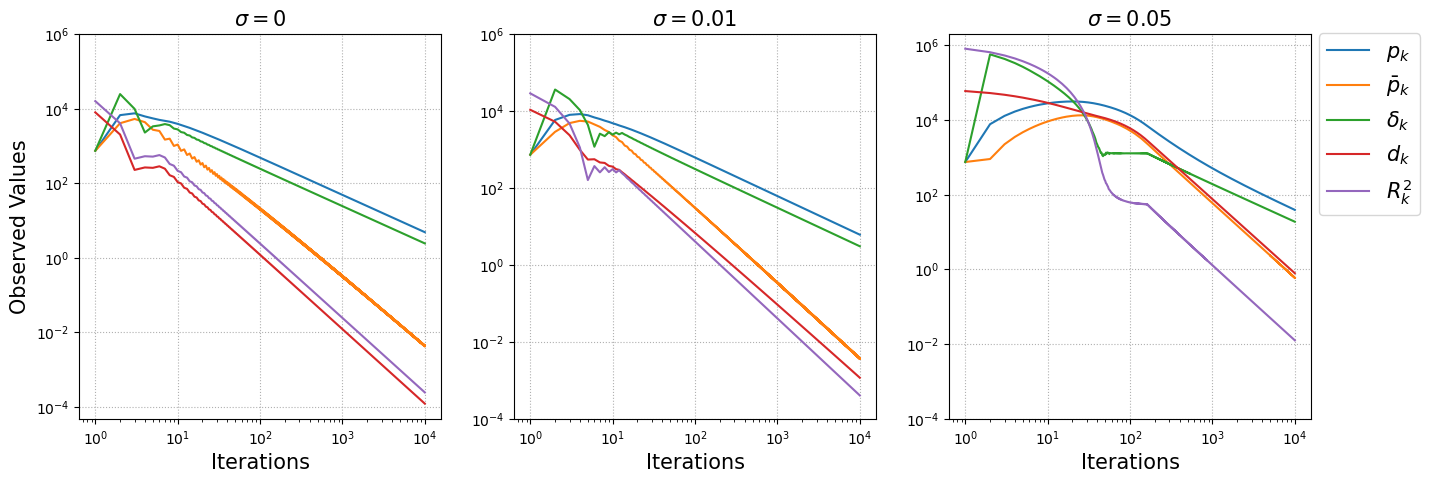

In [17]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(17, 5))

y = [10.0^i for i in -4:6]
function compute_yticks(y_values)
    min_power = floor(Int, log10(minimum(y_values)))
    max_power = ceil(Int, log10(maximum(y_values)))
    return [10.0^i for i in min_power:2:max_power]
end

ax1.loglog(1:T_sigma, primal_values4 - zeros(T_sigma))
ax1.loglog(1:T_sigma, average_iterate_primal_values4 - zeros(T_sigma))
ax1.loglog(1:T_sigma, f_list4 - zeros(T_sigma)) #f(x_k)-p*
ax1.loglog(1:T_sigma, zeros(T_sigma)-dual_values4)
ax1.loglog(1:T_sigma, distance_values4 - zeros(T_sigma))
ax1.grid(linestyle =":")
ax1.set_ylabel("Observed Values",fontsize=15)
ax1.set_xlabel("Iterations",fontsize=15)
ax1.set_title(L"\sigma = 0",fontsize=15)
ax1.set_yticks(compute_yticks(y))

ax2.loglog(1:T_sigma, primal_values5 - zeros(T_sigma))
ax2.loglog(1:T_sigma, average_iterate_primal_values5 - zeros(T_sigma))
ax2.loglog(1:T_sigma, f_list5 - zeros(T_sigma))
ax2.loglog(1:T_sigma, zeros(T_sigma)-dual_values5)
ax2.loglog(1:T_sigma, distance_values5 - zeros(T_sigma))
ax2.set_xlabel("Iterations",fontsize=15)
ax2.grid(linestyle =":")
ax2.set_title(L"\sigma = 0.01",fontsize=15)
ax2.set_yticks(compute_yticks(y))

ax3.loglog(1:T_sigma, primal_values6 - zeros(T_sigma), label=L"p_k")
ax3.loglog(1:T_sigma, average_iterate_primal_values6 - zeros(T_sigma), label=L"\bar p_k")
ax3.loglog(1:T_sigma, f_list6 - zeros(T_sigma), label=L"\delta_k")
ax3.loglog(1:T_sigma, zeros(T_sigma)-dual_values6, label=L"d_k")
ax3.loglog(1:T_sigma, distance_values6 - zeros(T_sigma), label=L"R_k^2")
ax3.set_xlabel("Iterations",fontsize=15)
ax3.grid(linestyle =":")
ax3.set_title(L"\sigma = 0.05",fontsize=15)
ax3.set_yticks(compute_yticks(y))

fig.legend(loc="center right", ncol=1, bbox_to_anchor=(0.92, 0.7),fontsize=15)
fig.subplots_adjust(right=0.85)
savefig("figure22_sigma_After_modify_lambda",bbox_inches ="tight",pad_inches = 0)

## Section 1

When $\beta = 0$, $\sigma = 0$, comparing different $\lambda$.

In [18]:
sigma=0

A1_sigma = A1(xtrue,n,m)
A2_sigma = A2(xtrue,n,m,sigma)
b1_sigma = A1_sigma*xtrue
b2_sigma = A2_sigma*xtrue
obj_sigma = x -> norm(A1_sigma*x-b1_sigma,p1)^p1 + 0.5*norm(A2_sigma*x-b2_sigma,p2)^p2
objGrad_sigma = x -> ForwardDiff.gradient(obj_sigma, x)
mu_sigma = eigmin(A2_sigma'*A2_sigma)

T_sigma = 10000
lambda_list_sigma1 = [1 for i in 1:T_sigma+1]
lambda_list_sigma2 = [i for i in 1:T_sigma+1]
lambda_list_sigma3 = [i^2 for i in 1:T_sigma+1]
lambda_list_sigma4 = [i^3.0 for i in 1:T_sigma+1]
lambda_list_sigma5 = [i^4.0 for i in 1:T_sigma+1]
lambda_list_sigma6 = find_lambdas(T_sigma+1,mu_sigma)
beta_sigma = 0

primal_values1, dual_values1,_,_,_,distance_values1 = subgradientMethod(obj_sigma, objGrad_sigma, xtrue, mu_sigma, T_sigma, n, lambda_list_sigma1, beta_sigma)
primal_gap_bound1,dual_gap_bound1,distance_optimal_bound1=three_important_bounds(lambda_list_sigma1,A1_sigma,A2_sigma,beta_sigma,xtrue,zeros(n),T_sigma)
primal_values2, dual_values2,_,_,_,distance_values2 = subgradientMethod(obj_sigma, objGrad_sigma, xtrue, mu_sigma, T_sigma, n, lambda_list_sigma2, beta_sigma)
primal_gap_bound2,dual_gap_bound2,distance_optimal_bound2=three_important_bounds(lambda_list_sigma2,A1_sigma,A2_sigma,beta_sigma,xtrue,zeros(n),T_sigma)
primal_values3, dual_values3,_,_,_,distance_values3 = subgradientMethod(obj_sigma, objGrad_sigma, xtrue, mu_sigma, T_sigma, n, lambda_list_sigma3, beta_sigma)
primal_gap_bound3,dual_gap_bound3,distance_optimal_bound3=three_important_bounds(lambda_list_sigma3,A1_sigma,A2_sigma,beta_sigma,xtrue,zeros(n),T_sigma)
primal_values4, dual_values4,_,_,_,distance_values4 = subgradientMethod(obj_sigma, objGrad_sigma, xtrue, mu_sigma, T_sigma, n, lambda_list_sigma4, beta_sigma)
primal_gap_bound4,dual_gap_bound4,distance_optimal_bound4=three_important_bounds(lambda_list_sigma4,A1_sigma,A2_sigma,beta_sigma,xtrue,zeros(n),T_sigma)
primal_values5, dual_values5,_,_,_,distance_values5 = subgradientMethod(obj_sigma, objGrad_sigma, xtrue, mu_sigma, T_sigma, n, lambda_list_sigma5, beta_sigma)
primal_gap_bound5,dual_gap_bound5,distance_optimal_bound5=three_important_bounds(lambda_list_sigma5,A1_sigma,A2_sigma,beta_sigma,xtrue,zeros(n),T_sigma)
primal_values6, dual_values6,_,_,_,distance_values6 = subgradientMethod(obj_sigma, objGrad_sigma, xtrue, mu_sigma, T_sigma, n, lambda_list_sigma6, beta_sigma)
primal_gap_bound6,dual_gap_bound6,distance_optimal_bound6=three_important_bounds(lambda_list_sigma6,A1_sigma,A2_sigma,beta_sigma,xtrue,zeros(n),T_sigma)


3
7.9926416154745435e6
27989.100644618757
6
7.9926416154745435e6
147246.08089252864
10
7.9926416154745435e6
1.2547398748123306e6
13
7.9926416154745435e6
1.750728423859033e7
17
7.9926416154745435e6
3.858710589316818e8
5
7.9926416154745435e6
31348.071353590156


([8.023989686828134e6, 6.0101552472827025e6, 4.880312256727796e6, 4.135334785509023e6, 3.6004381826449484e6, 3.194967432007425e6, 2.875679953341244e6, 2.617019369999877e6, 2.402797836543066e6, 2.222211958418729e6  …  3196.427754018334, 3196.1081741197786, 3195.788658121436, 3195.4692060041416, 3195.1498177487383, 3194.8304933360787, 3194.5112327470206, 3194.1920359624314, 3193.8729029631854, 3193.5538337301637], [8.023989686828134e6, 6.0101552472827025e6, 4.880312256727796e6, 4.135334785509023e6, 3.6004381826449484e6, 3.194967432007425e6, 2.875679953341244e6, 2.617019369999877e6, 2.402797836543066e6, 2.222211958418729e6  …  3196.427754018334, 3196.1081741197786, 3195.788658121436, 3195.4692060041416, 3195.1498177487383, 3194.8304933360787, 3194.5112327470206, 3194.1920359624314, 3193.8729029631854, 3193.5538337301637], [1.6047979373656267e7, 1.2020310494565405e7, 9.760624513455592e6, 8.270669571018046e6, 7.200876365289897e6, 6.38993486401485e6, 5.751359906682488e6, 5.234038739999754e6,

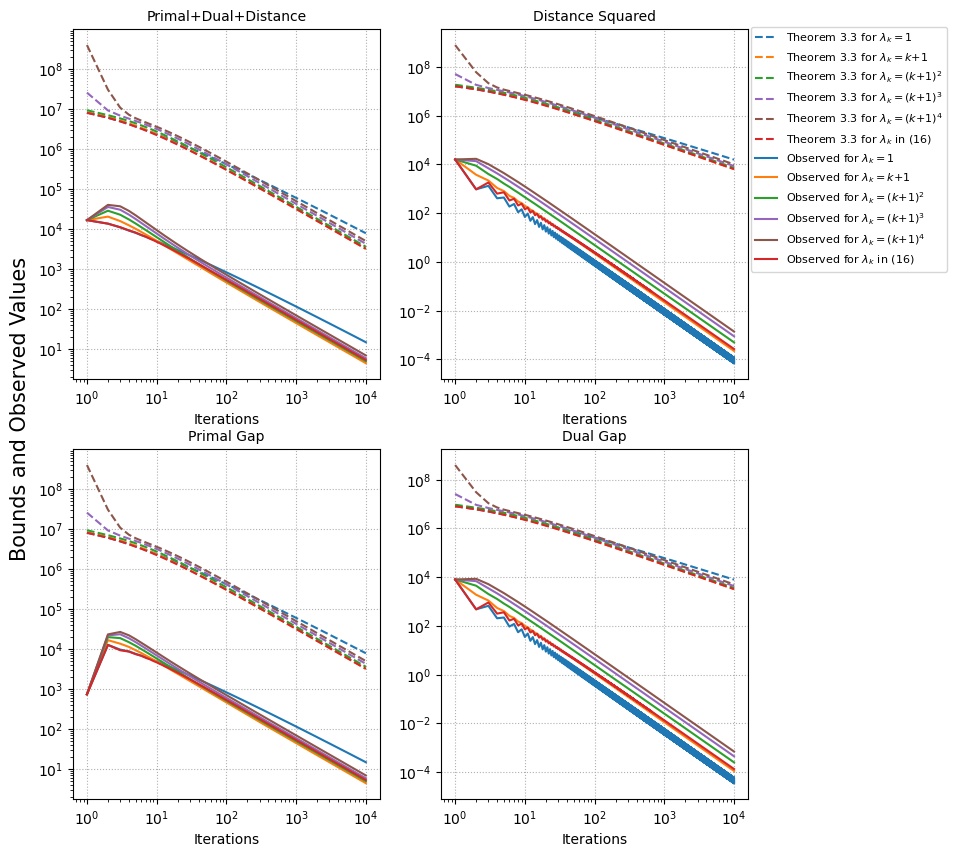

In [19]:
fig, (ax3, ax1, ax4, ax2) = plt.subplots(2, 2, figsize=(10, 10))

y = [10.0^i for i in -4:8]
function compute_yticks(y_values)
    min_power = floor(Int, log10(minimum(y_values)))
    max_power = ceil(Int, log10(maximum(y_values)))
    return [10.0^i for i in min_power:2:max_power]
end

ax1.loglog(1:T_sigma, primal_gap_bound1 - zeros(T_sigma),linestyle ="--",color="tab:blue")
ax1.loglog(1:T_sigma, primal_gap_bound2 - zeros(T_sigma),linestyle ="--",color="tab:orange")
ax1.loglog(1:T_sigma, primal_gap_bound3 - zeros(T_sigma),linestyle ="--",color="tab:green")
ax1.loglog(1:T_sigma, primal_gap_bound4 - zeros(T_sigma),linestyle ="--",color="tab:purple")
ax1.loglog(1:T_sigma, primal_gap_bound5 - zeros(T_sigma),linestyle ="--",color="tab:brown")
ax1.loglog(1:T_sigma, primal_gap_bound6 - zeros(T_sigma),linestyle ="--",color="tab:red")
ax1.loglog(1:T_sigma, primal_values1 - zeros(T_sigma),color="tab:blue")
ax1.loglog(1:T_sigma, primal_values2 - zeros(T_sigma),color="tab:orange")
ax1.loglog(1:T_sigma, primal_values3 - zeros(T_sigma),color="tab:green")
ax1.loglog(1:T_sigma, primal_values4 - zeros(T_sigma),color="tab:purple")
ax1.loglog(1:T_sigma, primal_values5 - zeros(T_sigma),color="tab:brown")
ax1.loglog(1:T_sigma, primal_values6 - zeros(T_sigma),color="tab:red")
ax1.set_xlabel("Iterations",fontsize=10)
ax1.grid(linestyle =":")
ax1.set_title("Primal Gap",fontsize=10)

ax2.loglog(1:T_sigma, dual_gap_bound1 - zeros(T_sigma),linestyle ="--",color="tab:blue")
ax2.loglog(1:T_sigma, dual_gap_bound2 - zeros(T_sigma),linestyle ="--",color="tab:orange")
ax2.loglog(1:T_sigma, dual_gap_bound3 - zeros(T_sigma),linestyle ="--",color="tab:green")
ax2.loglog(1:T_sigma, dual_gap_bound4 - zeros(T_sigma),linestyle ="--",color="tab:purple")
ax2.loglog(1:T_sigma, dual_gap_bound5 - zeros(T_sigma),linestyle ="--",color="tab:brown")
ax2.loglog(1:T_sigma, dual_gap_bound6 - zeros(T_sigma),linestyle ="--",color="tab:red")
ax2.loglog(1:T_sigma, zeros(T_sigma)-dual_values1,color="tab:blue")
ax2.loglog(1:T_sigma, zeros(T_sigma)-dual_values2,color="tab:orange")
ax2.loglog(1:T_sigma, zeros(T_sigma)-dual_values3,color="tab:green")
ax2.loglog(1:T_sigma, zeros(T_sigma)-dual_values4,color="tab:purple")
ax2.loglog(1:T_sigma, zeros(T_sigma)-dual_values5,color="tab:brown")
ax2.loglog(1:T_sigma, zeros(T_sigma)-dual_values6,color="tab:red")
ax2.set_xlabel("Iterations",fontsize=10)
ax2.grid(linestyle =":")
ax2.set_title("Dual Gap",fontsize=10)
ax2.set_yticks(compute_yticks(y))

ax4.loglog(1:T_sigma, distance_optimal_bound1 - zeros(T_sigma),linestyle ="--",color="tab:blue")
ax4.loglog(1:T_sigma, distance_optimal_bound2 - zeros(T_sigma),linestyle ="--",color="tab:orange")
ax4.loglog(1:T_sigma, distance_optimal_bound3 - zeros(T_sigma),linestyle ="--",color="tab:green")
ax4.loglog(1:T_sigma, distance_optimal_bound4 - zeros(T_sigma),linestyle ="--",color="tab:purple")
ax4.loglog(1:T_sigma, distance_optimal_bound5 - zeros(T_sigma),linestyle ="--",color="tab:brown")
ax4.loglog(1:T_sigma, distance_optimal_bound6 - zeros(T_sigma),linestyle ="--",color="tab:red")
ax4.loglog(1:T_sigma, distance_values1-zeros(T_sigma),color="tab:blue")
ax4.loglog(1:T_sigma, distance_values2-zeros(T_sigma),color="tab:orange")
ax4.loglog(1:T_sigma, distance_values3-zeros(T_sigma),color="tab:green")
ax4.loglog(1:T_sigma, distance_values4-zeros(T_sigma),color="tab:purple")
ax4.loglog(1:T_sigma, distance_values5-zeros(T_sigma),color="tab:brown")
ax4.loglog(1:T_sigma, distance_values6-zeros(T_sigma),color="tab:red")
ax4.set_xlabel("Iterations",fontsize=10)
ax4.grid(linestyle =":")
ax4.set_title("Distance Squared",fontsize=10)
ax4.set_yticks(compute_yticks(y))

ax3.loglog(1:T_sigma, primal_gap_bound1 - zeros(T_sigma),label=L"\mathrm{Theorem\ 3.3\ for\ }\lambda_k{=}1",linestyle ="--",color="tab:blue")
ax3.loglog(1:T_sigma, primal_gap_bound2 - zeros(T_sigma),label=L"\mathrm{Theorem\ 3.3\ for\ }\lambda_k{=}k{+}1",linestyle ="--",color="tab:orange")
ax3.loglog(1:T_sigma, primal_gap_bound3 - zeros(T_sigma),label=L"\mathrm{Theorem\ 3.3\ for\ }\lambda_k{=}(k{+}1)^2",linestyle ="--",color="tab:green")
ax3.loglog(1:T_sigma, primal_gap_bound4 - zeros(T_sigma),label=L"\mathrm{Theorem\ 3.3\ for\ }\lambda_k{=}(k{+}1)^3",linestyle ="--",color="tab:purple")
ax3.loglog(1:T_sigma, primal_gap_bound5 - zeros(T_sigma),label=L"\mathrm{Theorem\ 3.3\ for\ }\lambda_k{=}(k{+}1)^4",linestyle ="--",color="tab:brown")
ax3.loglog(1:T_sigma, primal_gap_bound6 - zeros(T_sigma),label=L"\mathrm{Theorem\ 3.3\ for\ }\lambda_k\ \mathrm{in}\ (16)",linestyle ="--",color="tab:red")
ax3.loglog(1:T_sigma, primal_values1 - dual_values1 + (mu_sigma/2)*distance_values1, label=L"\mathrm{Observed\ for\ }\lambda_k{=}1", color="tab:blue")
ax3.loglog(1:T_sigma, primal_values2 - dual_values2 + (mu_sigma/2)*distance_values2,label=L"\mathrm{Observed\ for\ }\lambda_k{=}k{+}1", color="tab:orange")
ax3.loglog(1:T_sigma, primal_values3 - dual_values3 + (mu_sigma/2)*distance_values3,label=L"\mathrm{Observed\ for\ }\lambda_k{=}(k{+}1)^2", color="tab:green")
ax3.loglog(1:T_sigma, primal_values4 - dual_values4 + (mu_sigma/2)*distance_values4,label=L"\mathrm{Observed\ for\ }\lambda_k{=}(k{+}1)^3", color="tab:purple")
ax3.loglog(1:T_sigma, primal_values5 - dual_values5 + (mu_sigma/2)*distance_values5,label=L"\mathrm{Observed\ for\ }\lambda_k{=}(k{+}1)^4", color="tab:brown")
ax3.loglog(1:T_sigma, primal_values6 - dual_values6 + (mu_sigma/2)*distance_values6,label=L"\mathrm{Observed\ for\ }\lambda_k\ \mathrm{in}\ (16)", color="tab:red")
ax3.set_xlabel("Iterations",fontsize=10)
ax3.grid(linestyle =":")
ax3.set_title("Primal+Dual+Distance",fontsize=10)

fig.text(0.062, 0.5, "Bounds and Observed Values", va="center", rotation="vertical",fontsize=15)
fig.legend(loc="center right", ncol=1, bbox_to_anchor=(1.005, 0.76),fontsize=8)
fig.subplots_adjust(right=0.8)
savefig("figure24_different_lambda",bbox_inches ="tight",pad_inches = 0)

## Section 2

Compare the effectiveness of different $\sigma$ for $M_1/\mu, T_0, C_0$, when$\lambda_i=i$ and $\beta=0$.

In [20]:
T_sigma=10000
lambda_list_C0 = [i for i in 1:T_sigma+1]
beta_C0 = 0
function Find_C0(lambda_list_C0,sigma,beta_C0,xtrue,x0)
    A11 = A1(xtrue,m,n)
    A21 = A2(xtrue,m,n,sigma) 
    b1 = A11*xtrue
    b2 = A21*xtrue
    A = adjoint(A21)*A21
    mu = eigmin(A)
    norm_A1 = 0
    for i in 1:m
        a = norm(A11[:,i],2)
        norm_A1 += a    
    end
    M0=2*sqrt(2)*norm_A1
    M1 = 4*eigmax(A)
    obj = x -> norm(A11*x-b1,p1)^p1 + 0.5*norm(A21*x-b2,p2)^p2
    objGrad = x -> ForwardDiff.gradient(obj, x)
    _, _, _, f_list,_,_ = subgradientMethod(obj, objGrad, xtrue, mu, T_sigma, n, lambda_list_C0, beta_C0)
    T0 = find_T_0(lambda_list_C0,M1,mu,T_sigma,beta_C0)
    C0 = find_C_0(lambda_list_C0,f_list,M1,mu,T0,beta_C0) 
    return M1/mu, T0, C0
end

Find_C0 (generic function with 1 method)

In [21]:
#sigma=0
ratio,T0,C0=Find_C0(lambda_list_C0,0,beta_C0,xtrue,zeros(n))

(4.0, 6, 147246.08089252864)

In [22]:
#sigma=0.0001
ratio0,T00,C00=Find_C0(lambda_list_C0,0.0001,beta_C0,xtrue,zeros(n))

(4.021807281603907, 7, 149727.4726499545)

In [23]:
#sigma=0.001
ratio1,T01,C01=Find_C0(lambda_list_C0,0.001,beta_C0,xtrue,zeros(n))

(4.223563055409813, 7, 173474.6398221168)

In [24]:
#sigma=0.01
ratio2,T02,C02=Find_C0(lambda_list_C0,0.01,beta_C0,xtrue,zeros(n))

(6.911467756456015, 12, 698544.0974176718)

In [25]:
#sigma=0.02
ratio3,T03,C03=Find_C0(lambda_list_C0,0.02,beta_C0,xtrue,zeros(n))

(12.106739099602361, 23, 3.7695302037365357e6)

In [26]:
#sigma=0.05
ratio4,T04,C04=Find_C0(lambda_list_C0,0.05,beta_C0,xtrue,zeros(n))

(81.17876307532637, 161, 2.6627491452899132e23)

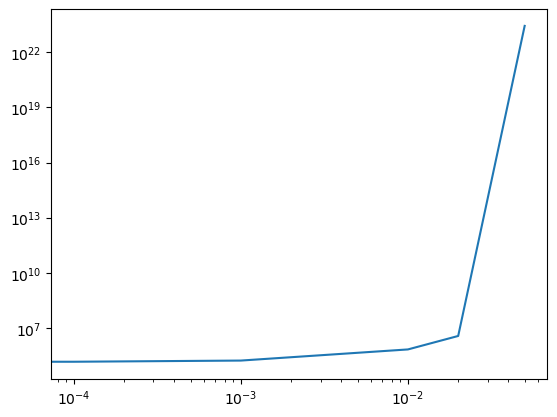

1-element Vector{PyCall.PyObject}:
 PyObject <matplotlib.lines.Line2D object at 0x1c70cfcd0>

In [27]:
loglog([0, 0.0001, 0.001, 0.01, 0.02, 0.05],[C0, C00, C01, C02, C03, C04])

## Section3
Set $\epsilon$ equals to 0.05, find out the first $k$ such that $ d_k, p_k, \bar p_k, \delta_k, p_k+d_k,\bar p_k+d_k,\delta_k+d_k \leq \epsilon$ under different choices of $\lambda_k$ when $\bar\beta=0$.

In [28]:
function stopping_criteria_pt(f, gradf, xtrue, mu, dim, beta,eps,p)

    x1 = zeros(dim)
    basicQuadratic = Quadratic(0.0,x1,1.0)
    xi = x1
    x_average = xi    #equals \sum_i sigma_i x_i
    f_average = f(x1) #equals \sum_i sigma_i f(x_i)
    modeli = Quadratic(f(x1)-norm(gradf(x1),2)^2/(2*mu), x1 - gradf(x1)/mu, mu) #equals \sum_i theta_i quadratic_i
 
    sum_of_lambda_i = 1 #1^p
    
    i=1
    while f_average>=eps
        i+=1
        #Compute penalized quadratic and update to next iterate
        penalizedQuadratic = addWeightedQuadratics(1.0, modeli, beta/sum_of_lambda_i, basicQuadratic)
        xi = penalizedQuadratic.minimizer

        #Compute new function values and gradients (at the newly computed next x_i) and update the model        
        fi = f(xi)
        gi = gradf(xi)
        eta = i^p/(sum_of_lambda_i + i^p)
        modeli = addWeightedQuadratics(1.0 - eta, modeli, eta, Quadratic(fi - norm(gi,2)^2/(2*mu), xi-gi/mu, mu))
        x_average = (1.0-eta)*x_average + eta*xi
        f_average = (1.0-eta)*f_average + eta*f(xi)

        sum_of_lambda_i += i^p
        
    end
    return i-1
end

stopping_criteria_pt (generic function with 1 method)

In [29]:
function stopping_criteria_pt_bar(f, gradf, xtrue, mu, dim, beta,eps,p)

    x1 = zeros(dim)
    basicQuadratic = Quadratic(0.0,x1,1.0)
    xi = x1
    x_average = xi    #equals \sum_i sigma_i x_i
    f_average = f(x1) #equals \sum_i sigma_i f(x_i)
    modeli = Quadratic(f(x1)-norm(gradf(x1),2)^2/(2*mu), x1 - gradf(x1)/mu, mu) #equals \sum_i theta_i quadratic_i
 
    sum_of_lambda_i = 1 #1^p
    
    i=1
    while f(x_average)>=eps
        i+=1
        #Compute penalized quadratic and update to next iterate
        penalizedQuadratic = addWeightedQuadratics(1.0, modeli, beta/sum_of_lambda_i, basicQuadratic)
        xi = penalizedQuadratic.minimizer

        #Compute new function values and gradients (at the newly computed next x_i) and update the model        
        fi = f(xi)
        gi = gradf(xi)
        eta = i^p/(sum_of_lambda_i + i^p)
        modeli = addWeightedQuadratics(1.0 - eta, modeli, eta, Quadratic(fi - norm(gi,2)^2/(2*mu), xi-gi/mu, mu))
        x_average = (1.0-eta)*x_average + eta*xi
        f_average = (1.0-eta)*f_average + eta*f(xi)

        sum_of_lambda_i += i^p
        
    end
    return i-1
end

stopping_criteria_pt_bar (generic function with 1 method)

In [30]:
function stopping_criteria_deltat(f, gradf, xtrue, mu, dim, beta,eps,p)

    x1 = zeros(dim)
    basicQuadratic = Quadratic(0.0,x1,1.0)
    xi = x1
    x_average = xi    #equals \sum_i sigma_i x_i
    f_average = f(x1) #equals \sum_i sigma_i f(x_i)
    modeli = Quadratic(f(x1)-norm(gradf(x1),2)^2/(2*mu), x1 - gradf(x1)/mu, mu) #equals \sum_i theta_i quadratic_i
 
    sum_of_lambda_i = 1 #1^p
   
    i=1
    while f(xi)>=eps
        i+=1
        #Compute penalized quadratic and update to next iterate
        penalizedQuadratic = addWeightedQuadratics(1.0, modeli, beta/sum_of_lambda_i, basicQuadratic)
        xi = penalizedQuadratic.minimizer

        #Compute new function values and gradients (at the newly computed next x_i) and update the model        
        fi = f(xi)
        gi = gradf(xi)
        eta = i^p/(sum_of_lambda_i + i^p)
        modeli = addWeightedQuadratics(1.0 - eta, modeli, eta, Quadratic(fi - norm(gi,2)^2/(2*mu), xi-gi/mu, mu))
        x_average = (1.0-eta)*x_average + eta*xi
        f_average = (1.0-eta)*f_average + eta*f(xi)

        sum_of_lambda_i += i^p

    end
    return i-1
end

stopping_criteria_deltat (generic function with 1 method)

In [31]:
function stopping_criteria_dt(f, gradf, xtrue, mu, dim, beta,eps,p)

    #We initialize at the origin for ease (start counting from i from 1 to avoid division by zero)    
    x1 = zeros(dim)
    basicQuadratic = Quadratic(0.0,x1,1.0)
    xi = x1
    x_average = xi    #equals \sum_i sigma_i x_i
    f_average = f(x1) #equals \sum_i sigma_i f(x_i)
    modeli = Quadratic(f(x1)-norm(gradf(x1),2)^2/(2*mu), x1 - gradf(x1)/mu, mu) #equals \sum_i theta_i quadratic_i
 
    sum_of_lambda_i = 1 #1^p
   
    i=1
    while -modeli.minimum>=eps
        i+=1
        #Compute penalized quadratic and update to next iterate
        penalizedQuadratic = addWeightedQuadratics(1.0, modeli, beta/sum_of_lambda_i, basicQuadratic)
        xi = penalizedQuadratic.minimizer

        #Compute new function values and gradients (at the newly computed next x_i) and update the model        
        fi = f(xi)
        gi = gradf(xi)
        eta = i^p/(sum_of_lambda_i + i^p)
        modeli = addWeightedQuadratics(1.0 - eta, modeli, eta, Quadratic(fi - norm(gi,2)^2/(2*mu), xi-gi/mu, mu))
        x_average = (1.0-eta)*x_average + eta*xi
        f_average = (1.0-eta)*f_average + eta*f(xi)

        sum_of_lambda_i += i^p 
        
    end
    return i-1
end

stopping_criteria_dt (generic function with 1 method)

In [32]:
function stopping_criteria_pt_dt(f, gradf, xtrue, mu, dim, beta,eps,p)

    #We initialize at the origin for ease (start counting from i from 1 to avoid division by zero)    
    x1 = zeros(dim)
    basicQuadratic = Quadratic(0.0,x1,1.0)
    xi = x1
    x_average = xi    #equals \sum_i sigma_i x_i
    f_average = f(x1) #equals \sum_i sigma_i f(x_i)
    modeli = Quadratic(f(x1)-norm(gradf(x1),2)^2/(2*mu), x1 - gradf(x1)/mu, mu) #equals \sum_i theta_i quadratic_i
 
    sum_of_lambda_i = 1 #1^p
  
    i=1
    while f_average-modeli.minimum>=eps
        i+=1
        #Compute penalized quadratic and update to next iterate
        penalizedQuadratic = addWeightedQuadratics(1.0, modeli, beta/sum_of_lambda_i, basicQuadratic)
        xi = penalizedQuadratic.minimizer

        #Compute new function values and gradients (at the newly computed next x_i) and update the model        
        fi = f(xi)
        gi = gradf(xi)
        eta = i^p/(sum_of_lambda_i + i^p)
        modeli = addWeightedQuadratics(1.0 - eta, modeli, eta, Quadratic(fi - norm(gi,2)^2/(2*mu), xi-gi/mu, mu))
        x_average = (1.0-eta)*x_average + eta*xi
        f_average = (1.0-eta)*f_average + eta*f(xi)

        sum_of_lambda_i += i^p
            
    end
    return i-1
end

stopping_criteria_pt_dt (generic function with 1 method)

In [33]:
function stopping_criteria_pt_bar_dt(f, gradf, xtrue, mu, dim, beta,eps,p)

    #We initialize at the origin for ease (start counting from i from 1 to avoid division by zero)    
    x1 = zeros(dim)
    basicQuadratic = Quadratic(0.0,x1,1.0)
    xi = x1
    x_average = xi    #equals \sum_i sigma_i x_i
    f_average = f(x1) #equals \sum_i sigma_i f(x_i)
    modeli = Quadratic(f(x1)-norm(gradf(x1),2)^2/(2*mu), x1 - gradf(x1)/mu, mu) #equals \sum_i theta_i quadratic_i
 
    sum_of_lambda_i = 1 #1^p
   
    i=1
    while f(x_average)-modeli.minimum>=eps
        i+=1
        #Compute penalized quadratic and update to next iterate
        penalizedQuadratic = addWeightedQuadratics(1.0, modeli, beta/sum_of_lambda_i, basicQuadratic)
        xi = penalizedQuadratic.minimizer

        #Compute new function values and gradients (at the newly computed next x_i) and update the model        
        fi = f(xi)
        gi = gradf(xi)
        eta = i^p/(sum_of_lambda_i + i^p)
        modeli = addWeightedQuadratics(1.0 - eta, modeli, eta, Quadratic(fi - norm(gi,2)^2/(2*mu), xi-gi/mu, mu))
        x_average = (1.0-eta)*x_average + eta*xi
        f_average = (1.0-eta)*f_average + eta*f(xi)

        sum_of_lambda_i += i^p
          
    end
    return i-1
end

stopping_criteria_pt_bar_dt (generic function with 1 method)

In [34]:
function stopping_criteria_deltat_dt(f, gradf, xtrue, mu, dim, beta,eps,p)

    #We initialize at the origin for ease (start counting from i from 1 to avoid division by zero)    
    x1 = zeros(dim)
    basicQuadratic = Quadratic(0.0,x1,1.0)
    xi = x1
    x_average = xi    #equals \sum_i sigma_i x_i
    f_average = f(x1) #equals \sum_i sigma_i f(x_i)
    modeli = Quadratic(f(x1)-norm(gradf(x1),2)^2/(2*mu), x1 - gradf(x1)/mu, mu) #equals \sum_i theta_i quadratic_i
 
    sum_of_lambda_i = 1 #1^p
 
    i=1
    while f(xi)-modeli.minimum>=eps
        i+=1
        #Compute penalized quadratic and update to next iterate
        penalizedQuadratic = addWeightedQuadratics(1.0, modeli, beta/sum_of_lambda_i, basicQuadratic)
        xi = penalizedQuadratic.minimizer

        #Compute new function values and gradients (at the newly computed next x_i) and update the model        
        fi = f(xi)
        gi = gradf(xi)
        eta = i^p/(sum_of_lambda_i + i^p)
        modeli = addWeightedQuadratics(1.0 - eta, modeli, eta, Quadratic(fi - norm(gi,2)^2/(2*mu), xi-gi/mu, mu))
        x_average = (1.0-eta)*x_average + eta*xi
        f_average = (1.0-eta)*f_average + eta*f(xi)

        sum_of_lambda_i += i^p
          
    end
    return i-1
end

stopping_criteria_deltat_dt (generic function with 1 method)

In [35]:
sigma=0

A1_sigma = A1(xtrue,n,m)
A2_sigma = A2(xtrue,n,m,sigma)
b1_sigma = A1_sigma*xtrue
b2_sigma = A2_sigma*xtrue
obj_sigma = x -> norm(A1_sigma*x-b1_sigma,p1)^p1 + 0.5*norm(A2_sigma*x-b2_sigma,p2)^p2
objGrad_sigma = x -> ForwardDiff.gradient(obj_sigma, x)
mu_sigma = eigmin(A2_sigma'*A2_sigma)
eps=0.05

0.05

In [36]:
#p = 0, beta = 0
pt_bar=stopping_criteria_pt_bar(obj_sigma, objGrad_sigma, xtrue, mu_sigma, n, 0,eps,0)
pt=stopping_criteria_pt(obj_sigma, objGrad_sigma, xtrue, mu_sigma, n, 0,eps,0)
deltat=stopping_criteria_deltat(obj_sigma, objGrad_sigma, xtrue, mu_sigma, n, 0,eps,0)
dt=stopping_criteria_dt(obj_sigma, objGrad_sigma, xtrue, mu_sigma, n, 0,eps,0)
gap_pt_bar_dt=stopping_criteria_pt_bar_dt(obj_sigma, objGrad_sigma, xtrue, mu_sigma, n, 0,eps,0)
gap_pt_dt=stopping_criteria_pt_dt(obj_sigma, objGrad_sigma, xtrue, mu_sigma, n, 0,eps,0)
gap_deltat_dt=stopping_criteria_deltat_dt(obj_sigma, objGrad_sigma, xtrue, mu_sigma, n, 0,eps,0)
(dt,pt_bar,gap_pt_bar_dt,deltat,gap_deltat_dt,pt,gap_pt_dt)

(263, 1204821, 1204821, 237426, 237428, 4713468, 4713468)

In [37]:
#p = 1,beta = 0
pt_bar=stopping_criteria_pt_bar(obj_sigma, objGrad_sigma, xtrue, mu_sigma, n, 0,eps,1)
pt=stopping_criteria_pt(obj_sigma, objGrad_sigma, xtrue, mu_sigma, n, 0,eps,1)
deltat=stopping_criteria_deltat(obj_sigma, objGrad_sigma, xtrue, mu_sigma, n, 0,eps,1)
dt=stopping_criteria_dt(obj_sigma, objGrad_sigma, xtrue, mu_sigma, n, 0,eps,1)
gap_pt_bar_dt=stopping_criteria_pt_bar_dt(obj_sigma, objGrad_sigma, xtrue, mu_sigma, n, 0,eps,1)
gap_pt_dt=stopping_criteria_pt_dt(obj_sigma, objGrad_sigma, xtrue, mu_sigma, n, 0,eps,1)
gap_deltat_dt=stopping_criteria_deltat_dt(obj_sigma, objGrad_sigma, xtrue, mu_sigma, n, 0,eps,1)
(dt,pt_bar,gap_pt_bar_dt,deltat,gap_deltat_dt,pt,gap_pt_dt)

(470, 1940, 2000, 443222, 443223, 886456, 886456)

In [38]:
#p = 2, beta = 0
pt_bar=stopping_criteria_pt_bar(obj_sigma, objGrad_sigma, xtrue, mu_sigma, n, 0,eps,2)
pt=stopping_criteria_pt(obj_sigma, objGrad_sigma, xtrue, mu_sigma, n, 0,eps,2)
deltat=stopping_criteria_deltat(obj_sigma, objGrad_sigma, xtrue, mu_sigma, n, 0,eps,2)
dt=stopping_criteria_dt(obj_sigma, objGrad_sigma, xtrue, mu_sigma, n, 0,eps,2)
gap_pt_bar_dt=stopping_criteria_pt_bar_dt(obj_sigma, objGrad_sigma, xtrue, mu_sigma, n, 0,eps,2)
gap_pt_dt=stopping_criteria_pt_dt(obj_sigma, objGrad_sigma, xtrue, mu_sigma, n, 0,eps,2)
gap_deltat_dt=stopping_criteria_deltat_dt(obj_sigma, objGrad_sigma, xtrue, mu_sigma, n, 0,eps,2)
(dt,pt_bar,gap_pt_bar_dt,deltat,gap_deltat_dt,pt,gap_pt_dt)

(705, 997, 1223, 664834, 664835, 997251, 997252)

In [39]:
#p = 3, beta = 0
pt_bar=stopping_criteria_pt_bar(obj_sigma, objGrad_sigma, xtrue, mu_sigma, n, 0,eps,3.0)
pt=stopping_criteria_pt(obj_sigma, objGrad_sigma, xtrue, mu_sigma, n, 0,eps,3.0)
deltat=stopping_criteria_deltat(obj_sigma, objGrad_sigma, xtrue, mu_sigma, n, 0,eps,3.0)
dt=stopping_criteria_dt(obj_sigma, objGrad_sigma, xtrue, mu_sigma, n, 0,eps,3.0)
gap_pt_bar_dt=stopping_criteria_pt_bar_dt(obj_sigma, objGrad_sigma, xtrue, mu_sigma, n, 0,eps,3.0)
gap_pt_dt=stopping_criteria_pt_dt(obj_sigma, objGrad_sigma, xtrue, mu_sigma, n, 0,eps,3.0)
gap_deltat_dt=stopping_criteria_deltat_dt(obj_sigma, objGrad_sigma, xtrue, mu_sigma, n, 0,eps,3.0)
(dt,pt_bar,gap_pt_bar_dt,deltat,gap_deltat_dt,pt,gap_pt_dt)

(941, 1331, 1630, 886445, 886446, 1181927, 1181928)

In [40]:
#p = 4, beta = 0
pt_bar=stopping_criteria_pt_bar(obj_sigma, objGrad_sigma, xtrue, mu_sigma, n, 0,eps,4.0)
pt=stopping_criteria_pt(obj_sigma, objGrad_sigma, xtrue, mu_sigma, n, 0,eps,4.0)
deltat=stopping_criteria_deltat(obj_sigma, objGrad_sigma, xtrue, mu_sigma, n, 0,eps,4.0)
dt=stopping_criteria_dt(obj_sigma, objGrad_sigma, xtrue, mu_sigma, n, 0,eps,4.0)
gap_pt_bar_dt=stopping_criteria_pt_bar_dt(obj_sigma, objGrad_sigma, xtrue, mu_sigma, n, 0,eps,4.0)
gap_pt_dt=stopping_criteria_pt_dt(obj_sigma, objGrad_sigma, xtrue, mu_sigma, n, 0,eps,4.0)
gap_deltat_dt=stopping_criteria_deltat_dt(obj_sigma, objGrad_sigma, xtrue, mu_sigma, n, 0,eps,4.0)
(dt,pt_bar,gap_pt_bar_dt,deltat,gap_deltat_dt,pt,gap_pt_dt)

(1176, 1664, 2038, 1108056, 1108058, 1385070, 1385071)

In [41]:
function stopping_criteria_pt_new_step(f, gradf, xtrue, mu, dim, beta,eps)

    x1 = zeros(dim)
    basicQuadratic = Quadratic(0.0,x1,1.0)
    xi = x1
    x_average = xi    #equals \sum_i sigma_i x_i
    f_average = f(x1) #equals \sum_i sigma_i f(x_i)
    modeli = Quadratic(f(x1)-norm(gradf(x1),2)^2/(2*mu), x1 - gradf(x1)/mu, mu) #equals \sum_i theta_i quadratic_i
 
    sum_of_lambda_i = 1 
    lambda_list=[1.0]
    alpha_list=[1/mu]
    i=1
    while f_average>=eps
        i+=1
        #Compute penalized quadratic and update to next iterate
        penalizedQuadratic = addWeightedQuadratics(1.0, modeli, beta/sum_of_lambda_i, basicQuadratic)
        xi = penalizedQuadratic.minimizer

        #Compute new function values and gradients (at the newly computed next x_i) and update the model        
        fi = f(xi)
        gi = gradf(xi)
        
        #Compute new coeficient lambda_i
        s1=0
        s2=0
        s3=0
        for j in 1:i-1
            s1+=lambda_list[j]
            s2+=lambda_list[j]*alpha_list[j]
            s3+=lambda_list[j]*((2/mu)-alpha_list[j])
        end
        lambda = s1*s2/s3
        alpha=lambda/(mu*(s1+lambda))
        append!(lambda_list,[lambda])
        append!(alpha_list,[alpha])
        
        eta = lambda/(sum_of_lambda_i + lambda)
        modeli = addWeightedQuadratics(1.0 - eta, modeli, eta, Quadratic(fi - norm(gi,2)^2/(2*mu), xi-gi/mu, mu))
        x_average = (1.0-eta)*x_average + eta*xi
        f_average = (1.0-eta)*f_average + eta*f(xi)

        sum_of_lambda_i += lambda
        
    end
    return i-1
end

stopping_criteria_pt_new_step (generic function with 1 method)

In [42]:
function stopping_criteria_pt_bar_new_step(f, gradf, xtrue, mu, dim, beta,eps)

    x1 = zeros(dim)
    basicQuadratic = Quadratic(0.0,x1,1.0)
    xi = x1
    x_average = xi    #equals \sum_i sigma_i x_i
    f_average = f(x1) #equals \sum_i sigma_i f(x_i)
    modeli = Quadratic(f(x1)-norm(gradf(x1),2)^2/(2*mu), x1 - gradf(x1)/mu, mu) #equals \sum_i theta_i quadratic_i
 
    sum_of_lambda_i = 1 
    lambda_list=[1.0]
    alpha_list=[1/mu]
    
    i=1
    while f(x_average)>=eps
        i+=1
        #Compute penalized quadratic and update to next iterate
        penalizedQuadratic = addWeightedQuadratics(1.0, modeli, beta/sum_of_lambda_i, basicQuadratic)
        xi = penalizedQuadratic.minimizer

        #Compute new function values and gradients (at the newly computed next x_i) and update the model        
        fi = f(xi)
        gi = gradf(xi)
        
        #Compute new coeficient lambda_i
        s1=0
        s2=0
        s3=0
        for j in 1:i-1
            s1+=lambda_list[j]
            s2+=lambda_list[j]*alpha_list[j]
            s3+=lambda_list[j]*((2/mu)-alpha_list[j])
        end
        lambda = s1*s2/s3
        alpha=lambda/(mu*(s1+lambda))
        append!(lambda_list,[lambda])
        append!(alpha_list,[alpha])
        
        eta = lambda/(sum_of_lambda_i + lambda)
        modeli = addWeightedQuadratics(1.0 - eta, modeli, eta, Quadratic(fi - norm(gi,2)^2/(2*mu), xi-gi/mu, mu))
        x_average = (1.0-eta)*x_average + eta*xi
        f_average = (1.0-eta)*f_average + eta*f(xi)

        sum_of_lambda_i += lambda
        
    end
    return i-1
end

stopping_criteria_pt_bar_new_step (generic function with 1 method)

In [43]:
function stopping_criteria_deltat_new_step(f, gradf, xtrue, mu, dim, beta,eps)

    x1 = zeros(dim)
    basicQuadratic = Quadratic(0.0,x1,1.0)
    xi = x1
    x_average = xi    #equals \sum_i sigma_i x_i
    f_average = f(x1) #equals \sum_i sigma_i f(x_i)
    modeli = Quadratic(f(x1)-norm(gradf(x1),2)^2/(2*mu), x1 - gradf(x1)/mu, mu) #equals \sum_i theta_i quadratic_i
 
    sum_of_lambda_i = 1 
    lambda_list=[1.0]
    alpha_list=[1/mu]
    
    i=1
    while f(xi)>=eps
        i+=1
        #Compute penalized quadratic and update to next iterate
        penalizedQuadratic = addWeightedQuadratics(1.0, modeli, beta/sum_of_lambda_i, basicQuadratic)
        xi = penalizedQuadratic.minimizer

        #Compute new function values and gradients (at the newly computed next x_i) and update the model        
        fi = f(xi)
        gi = gradf(xi)
        
        #Compute new coeficient lambda_i
        s1=0
        s2=0
        s3=0
        for j in 1:i-1
            s1+=lambda_list[j]
            s2+=lambda_list[j]*alpha_list[j]
            s3+=lambda_list[j]*((2/mu)-alpha_list[j])
        end
        lambda = s1*s2/s3
        alpha=lambda/(mu*(s1+lambda))
        append!(lambda_list,[lambda])
        append!(alpha_list,[alpha])
        
        eta = lambda/(sum_of_lambda_i + lambda)
        modeli = addWeightedQuadratics(1.0 - eta, modeli, eta, Quadratic(fi - norm(gi,2)^2/(2*mu), xi-gi/mu, mu))
        x_average = (1.0-eta)*x_average + eta*xi
        f_average = (1.0-eta)*f_average + eta*f(xi)

        sum_of_lambda_i += lambda

    end
    return i-1
end

stopping_criteria_deltat_new_step (generic function with 1 method)

In [44]:
function stopping_criteria_dt_new_step(f, gradf, xtrue, mu, dim, beta,eps)

    #We initialize at the origin for ease (start counting from i from 1 to avoid division by zero)    
    x1 = zeros(dim)
    basicQuadratic = Quadratic(0.0,x1,1.0)
    xi = x1
    x_average = xi    #equals \sum_i sigma_i x_i
    f_average = f(x1) #equals \sum_i sigma_i f(x_i)
    modeli = Quadratic(f(x1)-norm(gradf(x1),2)^2/(2*mu), x1 - gradf(x1)/mu, mu) #equals \sum_i theta_i quadratic_i
 
    sum_of_lambda_i = 1 
    lambda_list=[1.0]
    alpha_list=[1/mu]
    
    i=1
    while -modeli.minimum>=eps
        i+=1
        #Compute penalized quadratic and update to next iterate
        penalizedQuadratic = addWeightedQuadratics(1.0, modeli, beta/sum_of_lambda_i, basicQuadratic)
        xi = penalizedQuadratic.minimizer

        #Compute new function values and gradients (at the newly computed next x_i) and update the model        
        fi = f(xi)
        gi = gradf(xi)
        
        #Compute new coeficient lambda_i
        s1=0
        s2=0
        s3=0
        for j in 1:i-1
            s1+=lambda_list[j]
            s2+=lambda_list[j]*alpha_list[j]
            s3+=lambda_list[j]*((2/mu)-alpha_list[j])
        end
        lambda = s1*s2/s3
        alpha=lambda/(mu*(s1+lambda))
        append!(lambda_list,[lambda])
        append!(alpha_list,[alpha])
        
        eta = lambda/(sum_of_lambda_i + lambda)
        modeli = addWeightedQuadratics(1.0 - eta, modeli, eta, Quadratic(fi - norm(gi,2)^2/(2*mu), xi-gi/mu, mu))
        x_average = (1.0-eta)*x_average + eta*xi
        f_average = (1.0-eta)*f_average + eta*f(xi)

        sum_of_lambda_i += lambda
        
    end
    return i-1
end

stopping_criteria_dt_new_step (generic function with 1 method)

In [45]:
function stopping_criteria_pt_dt_new_step(f, gradf, xtrue, mu, dim, beta,eps)

    #We initialize at the origin for ease (start counting from i from 1 to avoid division by zero)    
    x1 = zeros(dim)
    basicQuadratic = Quadratic(0.0,x1,1.0)
    xi = x1
    x_average = xi    #equals \sum_i sigma_i x_i
    f_average = f(x1) #equals \sum_i sigma_i f(x_i)
    modeli = Quadratic(f(x1)-norm(gradf(x1),2)^2/(2*mu), x1 - gradf(x1)/mu, mu) #equals \sum_i theta_i quadratic_i
 
    sum_of_lambda_i = 1 
    lambda_list=[1.0]
    alpha_list=[1/mu]
    
    i=1
    while f_average-modeli.minimum >= eps
        i+=1
        #Compute penalized quadratic and update to next iterate
        penalizedQuadratic = addWeightedQuadratics(1.0, modeli, beta/sum_of_lambda_i, basicQuadratic)
        xi = penalizedQuadratic.minimizer

        #Compute new function values and gradients (at the newly computed next x_i) and update the model        
        fi = f(xi)
        gi = gradf(xi)
        
        #Compute new coeficient lambda_i
        s1=0
        s2=0
        s3=0
        for j in 1:i-1
            s1+=lambda_list[j]
            s2+=lambda_list[j]*alpha_list[j]
            s3+=lambda_list[j]*((2/mu)-alpha_list[j])
        end
        lambda = s1*s2/s3
        alpha=lambda/(mu*(s1+lambda))
        append!(lambda_list,[lambda])
        append!(alpha_list,[alpha])
        
        eta = lambda/(sum_of_lambda_i + lambda)
        modeli = addWeightedQuadratics(1.0 - eta, modeli, eta, Quadratic(fi - norm(gi,2)^2/(2*mu), xi-gi/mu, mu))
        x_average = (1.0-eta)*x_average + eta*xi
        f_average = (1.0-eta)*f_average + eta*f(xi)

        sum_of_lambda_i += lambda
            
    end
    return i-1
end

stopping_criteria_pt_dt_new_step (generic function with 1 method)

In [46]:
function stopping_criteria_pt_bar_dt_new_step(f, gradf, xtrue, mu, dim, beta,eps)

    #We initialize at the origin for ease (start counting from i from 1 to avoid division by zero)    
    x1 = zeros(dim)
    basicQuadratic = Quadratic(0.0,x1,1.0)
    xi = x1
    x_average = xi    #equals \sum_i sigma_i x_i
    f_average = f(x1) #equals \sum_i sigma_i f(x_i)
    modeli = Quadratic(f(x1)-norm(gradf(x1),2)^2/(2*mu), x1 - gradf(x1)/mu, mu) #equals \sum_i theta_i quadratic_i
 
    sum_of_lambda_i = 1
    lambda_list=[1.0]
    alpha_list=[1/mu]
    
    i=1
    while f(x_average)-modeli.minimum >= eps
        i+=1
        #Compute penalized quadratic and update to next iterate
        penalizedQuadratic = addWeightedQuadratics(1.0, modeli, beta/sum_of_lambda_i, basicQuadratic)
        xi = penalizedQuadratic.minimizer

        #Compute new function values and gradients (at the newly computed next x_i) and update the model        
        fi = f(xi)
        gi = gradf(xi)
        
        #Compute new coeficient lambda_i
        s1=0
        s2=0
        s3=0
        for j in 1:i-1
            s1+=lambda_list[j]
            s2+=lambda_list[j]*alpha_list[j]
            s3+=lambda_list[j]*((2/mu)-alpha_list[j])
        end
        lambda = s1*s2/s3
        alpha=lambda/(mu*(s1+lambda))
        append!(lambda_list,[lambda])
        append!(alpha_list,[alpha])
        
        eta = lambda/(sum_of_lambda_i + lambda)
        modeli = addWeightedQuadratics(1.0 - eta, modeli, eta, Quadratic(fi - norm(gi,2)^2/(2*mu), xi-gi/mu, mu))
        x_average = (1.0-eta)*x_average + eta*xi
        f_average = (1.0-eta)*f_average + eta*f(xi)

        sum_of_lambda_i += lambda
          
    end
    return i-1
end

stopping_criteria_pt_bar_dt_new_step (generic function with 1 method)

In [47]:
function stopping_criteria_deltat_dt_new_step(f, gradf, xtrue, mu, dim, beta,eps)

    #We initialize at the origin for ease (start counting from i from 1 to avoid division by zero)    
    x1 = zeros(dim)
    basicQuadratic = Quadratic(0.0,x1,1.0)
    xi = x1
    x_average = xi    #equals \sum_i sigma_i x_i
    f_average = f(x1) #equals \sum_i sigma_i f(x_i)
    modeli = Quadratic(f(x1)-norm(gradf(x1),2)^2/(2*mu), x1 - gradf(x1)/mu, mu) #equals \sum_i theta_i quadratic_i
 
    sum_of_lambda_i = 1
    lambda_list=[1.0]
    alpha_list=[1/mu]
    
    i=1
    while f(xi)-modeli.minimum >= eps
        i+=1
        #Compute penalized quadratic and update to next iterate
        penalizedQuadratic = addWeightedQuadratics(1.0, modeli, beta/sum_of_lambda_i, basicQuadratic)
        xi = penalizedQuadratic.minimizer

        #Compute new function values and gradients (at the newly computed next x_i) and update the model        
        fi = f(xi)
        gi = gradf(xi)
        
        #Compute new coeficient lambda_i
        s1=0
        s2=0
        s3=0
        for j in 1:i-1
            s1+=lambda_list[j]
            s2+=lambda_list[j]*alpha_list[j]
            s3+=lambda_list[j]*((2/mu)-alpha_list[j])
        end
        lambda = s1*s2/s3
        alpha=lambda/(mu*(s1+lambda))
        append!(lambda_list,[lambda])
        append!(alpha_list,[alpha])
        
        eta = lambda/(sum_of_lambda_i + lambda)
        modeli = addWeightedQuadratics(1.0 - eta, modeli, eta, Quadratic(fi - norm(gi,2)^2/(2*mu), xi-gi/mu, mu))
        x_average = (1.0-eta)*x_average + eta*xi
        f_average = (1.0-eta)*f_average + eta*f(xi)

        sum_of_lambda_i += lambda
          
    end
    return i-1
end

stopping_criteria_deltat_dt_new_step (generic function with 1 method)

In [48]:
#beta = 0, eps = 0.05, lambda is defined by formula (16)
pt_bar=stopping_criteria_pt_bar_new_step(obj_sigma, objGrad_sigma, xtrue, mu_sigma, n, 0,eps)
pt=stopping_criteria_pt_new_step(obj_sigma, objGrad_sigma, xtrue, mu_sigma, n, 0,eps)
deltat=stopping_criteria_deltat_new_step(obj_sigma, objGrad_sigma, xtrue, mu_sigma, n, 0,eps)
dt=stopping_criteria_dt_new_step(obj_sigma, objGrad_sigma, xtrue, mu_sigma, n, 0,eps)
gap_pt_bar_dt=stopping_criteria_pt_bar_dt_new_step(obj_sigma, objGrad_sigma, xtrue, mu_sigma, n, 0,eps)
gap_pt_dt=stopping_criteria_pt_dt_new_step(obj_sigma, objGrad_sigma, xtrue, mu_sigma, n, 0,eps)
gap_deltat_dt=stopping_criteria_deltat_dt_new_step(obj_sigma, objGrad_sigma, xtrue, mu_sigma, n, 0,eps)
(dt,pt_bar,gap_pt_bar_dt,deltat,gap_deltat_dt,pt,gap_pt_dt)

(509, 4122, 4156, 533876, 533876, 1067789, 1067790)

### comment:
In our experiment, some notations are different with what we use in our Numerical Experience and Validation section. I will clarify them now: $M_0$ we used here is the same as $L_0$ in our paper, $M_1$ is the same as $L_1$, $A_1$ is the same as $A$, $A_2$ is the same as $C$, $b_1$ is the same as $b$ and $b_2$ is the same as $d$.